#Libraries

In [2]:
!pip install transformers pandas numpy scikit-learn torch

import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

2025-05-16 10:43:39.173038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747392219.371569      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747392219.428086      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#Data Preprocessing

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# 1. CORRECTED XML PARSING
def parse_xml(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        data = []

        for sentence in root.findall('sentence'):
            text = sentence.find('text').text
            aspects = []

            # Handle different XML structures
            aspect_container = sentence.find('aspectTerms') or sentence.find('Opinions')

            if aspect_container is not None:
                for aspect in aspect_container.findall('aspectTerm') or aspect_container.findall('Opinion'):
                    polarity = aspect.get('polarity') or aspect.get('sentiment')

                    if polarity.lower() in ['positive', 'negative', 'neutral']:
                        aspects.append({
                            'term': aspect.get('term') or aspect.get('target'),
                            'polarity': polarity.lower()
                        })

            if aspects:
                data.append({'text': text, 'aspects': aspects})

        return data

    except Exception as e:
        print(f"Error parsing {file_path}: {str(e)}")
        return []

#LOAD DATA

In [4]:
tree = ET.parse('/kaggle/input/semeval-16-dataset/restaurants_train_sb1.xml')
root = tree.getroot()
print(root.tag)


Reviews


In [5]:
for child in root:
    print(child.tag)
    break  # Just to get a glimpse


Review


In [6]:
def parse_xml(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    data = []

    for review in root.findall('Review'):
        for sentences in review.findall('sentences'):
            for sentence in sentences.findall('sentence'):
                text_tag = sentence.find('text')
                if text_tag is None:
                    continue

                text = text_tag.text
                aspects = []

                opinions = sentence.find('Opinions')
                if opinions is not None:
                    for opinion in opinions.findall('Opinion'):
                        category = opinion.attrib.get('category')
                        polarity = opinion.attrib.get('polarity')
                        if category and polarity:
                            aspects.append({'term': category, 'polarity': polarity})

                if aspects:
                    data.append({'text': text, 'aspects': aspects})

    print(f"Parsed {len(data)} sentences from {filename}")
    return data


In [7]:
train_data = parse_xml('/kaggle/input/semeval-16-dataset/restaurants_train_sb1.xml')
test_data = parse_xml('/kaggle/input/semeval-16-dataset/restaurants_test_sb1.xml')

# train_df = create_dataframe(train_data)
# test_df = create_dataframe(test_data)

# print(train_df.head())
# print(test_df.head())

Parsed 1708 sentences from /kaggle/input/semeval-16-dataset/restaurants_train_sb1.xml
Parsed 587 sentences from /kaggle/input/semeval-16-dataset/restaurants_test_sb1.xml


In [8]:
# Print dataset sizes
print("Train size:", len(train_data))
print("Test size:", len(test_data))


Train size: 1708
Test size: 587


In [9]:
# 3. PREPARE DATAFRAME
def create_dataframe(data):
    rows = []
    label_map = {'positive': 0, 'negative': 1, 'neutral': 2}

    for item in data:
        for aspect in item['aspects']:
            rows.append({
                'text': item['text'],
                'aspect': aspect['term'],
                'label': label_map[aspect['polarity']]
            })

    return pd.DataFrame(rows)

train_df = create_dataframe(train_data)
test_df = create_dataframe(test_data)

print("\nTraining data sample:")
print(train_df.head())
print("\nLabel distribution:")
print(train_df['label'].value_counts())




Training data sample:
                                                text              aspect  \
0  Judging from previous posts this used to be a ...  RESTAURANT#GENERAL   
1  We, there were four of us, arrived at noon - t...     SERVICE#GENERAL   
2  They never brought us complimentary noodles, i...     SERVICE#GENERAL   
3  The food was lousy - too sweet or too salty an...        FOOD#QUALITY   
4  The food was lousy - too sweet or too salty an...  FOOD#STYLE_OPTIONS   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  

Label distribution:
label
0    1657
1     749
2     101
Name: count, dtype: int64


In [10]:
def parse_xml(filename):
    import xml.etree.ElementTree as ET
    tree = ET.parse(filename)
    root = tree.getroot()

    data = []

    for review in root.findall('Review'):
        for sentence in review.find('sentences').findall('sentence'):
            text = sentence.find('text').text
            opinions = sentence.find('Opinions')

            aspects = []
            if opinions is not None and len(opinions.findall('Opinion')) > 0:
                for opinion in opinions.findall('Opinion'):
                    category = opinion.attrib.get('category')
                    polarity = opinion.attrib.get('polarity')
                    if polarity:  # Only include if polarity is present
                        aspects.append({'term': category, 'polarity': polarity})

            if aspects:  # Only keep sentences with labeled aspects
                data.append({'text': text, 'aspects': aspects})

    return data


# MODEL

In [11]:

if not train_df.empty:
    print("\nProceeding with model training...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    # Add your training code here
else:
    print("\nERROR: No valid training data found. Please check your XML files.")


Proceeding with model training...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from torch.utils.data import Dataset

class ABSADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['text']
        aspect = row['aspect']
        label = row['label']

        encoding = self.tokenizer(
            text, aspect,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [14]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

train_dataset = ABSADataset(train_df, tokenizer)
val_dataset = ABSADataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [15]:
# from transformers import AdamW
# from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(10):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f'Epoch {epoch+1}')

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} loss: {total_loss / len(train_loader):.4f}")


Epoch 1: 100%|██████████| 141/141 [00:30<00:00,  4.57it/s, loss=0.411]


Epoch 1 loss: 0.5545


Epoch 2: 100%|██████████| 141/141 [00:30<00:00,  4.67it/s, loss=0.259]


Epoch 2 loss: 0.3527


Epoch 3: 100%|██████████| 141/141 [00:30<00:00,  4.67it/s, loss=0.309] 


Epoch 3 loss: 0.2817


Epoch 4: 100%|██████████| 141/141 [00:30<00:00,  4.67it/s, loss=0.225] 


Epoch 4 loss: 0.2508


Epoch 5: 100%|██████████| 141/141 [00:30<00:00,  4.66it/s, loss=0.264] 


Epoch 5 loss: 0.2207


Epoch 6: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s, loss=0.232] 


Epoch 6 loss: 0.1854


Epoch 7: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s, loss=0.328]  


Epoch 7 loss: 0.1624


Epoch 8: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s, loss=0.166]  


Epoch 8 loss: 0.1289


Epoch 9: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s, loss=0.0823] 


Epoch 9 loss: 0.1165


Epoch 10: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s, loss=0.104]  

Epoch 10 loss: 0.1038


In [16]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {correct / total:.4f}")


Validation Accuracy: 0.8446


In [17]:
model.save_pretrained("bert-aspect-sentiment")
tokenizer.save_pretrained("bert-aspect-sentiment")


('bert-aspect-sentiment/tokenizer_config.json',
 'bert-aspect-sentiment/special_tokens_map.json',
 'bert-aspect-sentiment/vocab.txt',
 'bert-aspect-sentiment/added_tokens.json')

In [18]:
test_dataset = ABSADataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)


In [19]:
model.eval()
predictions = []
true_labels = []
texts = []
aspects = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


In [20]:
print(len(test_df))  # Should be > 0


859


In [21]:
def parse_xml(filename):
    import xml.etree.ElementTree as ET
    tree = ET.parse(filename)
    root = tree.getroot()

    data = []

    for review in root.findall('Review'):
        for sentence in review.find('sentences').findall('sentence'):
            text = sentence.find('text').text
            opinions = sentence.find('Opinions')

            aspects = []
            if opinions is not None and len(opinions.findall('Opinion')) > 0:
                for opinion in opinions.findall('Opinion'):
                    category = opinion.attrib.get('category')
                    polarity = opinion.attrib.get('polarity')
                    if polarity:  # Only include if polarity is present
                        aspects.append({'term': category, 'polarity': polarity})

            if aspects:  # Only keep sentences with labeled aspects
                data.append({'text': text, 'aspects': aspects})

    return data


In [22]:
train_data = parse_xml('/kaggle/input/semeval-16-dataset/restaurants_train_sb1.xml')
test_data = parse_xml('/kaggle/input/semeval-16-dataset/restaurants_test_sb1.xml')

train_df = create_dataframe(train_data)
test_df = create_dataframe(test_data)

print(train_df.head())
print(test_df.head())


                                                text              aspect  \
0  Judging from previous posts this used to be a ...  RESTAURANT#GENERAL   
1  We, there were four of us, arrived at noon - t...     SERVICE#GENERAL   
2  They never brought us complimentary noodles, i...     SERVICE#GENERAL   
3  The food was lousy - too sweet or too salty an...        FOOD#QUALITY   
4  The food was lousy - too sweet or too salty an...  FOOD#STYLE_OPTIONS   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  
                                     text              aspect  label
0                                    Yum!        FOOD#QUALITY      0
1               Serves really good sushi.        FOOD#QUALITY      0
2  Not the biggest portions but adequate.  FOOD#STYLE_OPTIONS      2
3       Green Tea creme brulee is a must!        FOOD#QUALITY      0
4  Don't leave the restaurant without it.        FOOD#QUALITY      0


In [23]:
test_dataset = ABSADataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


In [24]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions, labels=[0, 1, 2],
                            target_names=['positive', 'negative', 'neutral']))


              precision    recall  f1-score   support

    positive       0.95      0.91      0.93       611
    negative       0.74      0.89      0.81       204
     neutral       0.47      0.34      0.39        44

    accuracy                           0.87       859
   macro avg       0.72      0.71      0.71       859
weighted avg       0.88      0.87      0.87       859



In [25]:
from sklearn.metrics import classification_report

label_map_rev = {0: 'positive', 1: 'negative', 2: 'neutral'}

print("Classification Report:")
print(classification_report(true_labels, predictions, labels=[0, 1, 2], target_names=['positive', 'negative', 'neutral']))

# Optional: Attach predictions to DataFrame
test_df['predicted'] = predictions
test_df['predicted_label'] = test_df['predicted'].map(label_map_rev)
test_df['true_label'] = test_df['label'].map(label_map_rev)

print("\n🔍 Sample Predictions:")
print(test_df[['text', 'aspect', 'true_label', 'predicted_label']].head(10))


Classification Report:
              precision    recall  f1-score   support

    positive       0.95      0.91      0.93       611
    negative       0.74      0.89      0.81       204
     neutral       0.47      0.34      0.39        44

    accuracy                           0.87       859
   macro avg       0.72      0.71      0.71       859
weighted avg       0.88      0.87      0.87       859


🔍 Sample Predictions:
                                                text              aspect  \
0                                               Yum!        FOOD#QUALITY   
1                          Serves really good sushi.        FOOD#QUALITY   
2             Not the biggest portions but adequate.  FOOD#STYLE_OPTIONS   
3                  Green Tea creme brulee is a must!        FOOD#QUALITY   
4             Don't leave the restaurant without it.        FOOD#QUALITY   
5                                      No Comparison  RESTAURANT#GENERAL   
6             – I can't say enough about 

In [26]:

print("\n Sample Predictions:")
test_df[['text', 'aspect', 'true_label', 'predicted_label']].head(10)


 Sample Predictions:


,text,aspect,true_label,predicted_label
0,Yum!,FOOD#QUALITY,positive,positive
1,Serves really good sushi.,FOOD#QUALITY,positive,positive
2,Not the biggest portions but adequate.,FOOD#STYLE_OPTIONS,neutral,negative
3,Green Tea creme brulee is a must!,FOOD#QUALITY,positive,positive
4,Don't leave the restaurant without it.,FOOD#QUALITY,positive,negative
5,No Comparison,RESTAURANT#GENERAL,positive,negative
6,– I can't say enough about this place.,RESTAURANT#GENERAL,positive,positive
7,It has great sushi and even better service.,FOOD#QUALITY,positive,positive
8,It has great sushi and even better service.,SERVICE#GENERAL,positive,positive
9,The entire staff was extremely accomodating an...,SERVICE#GENERAL,positive,positive


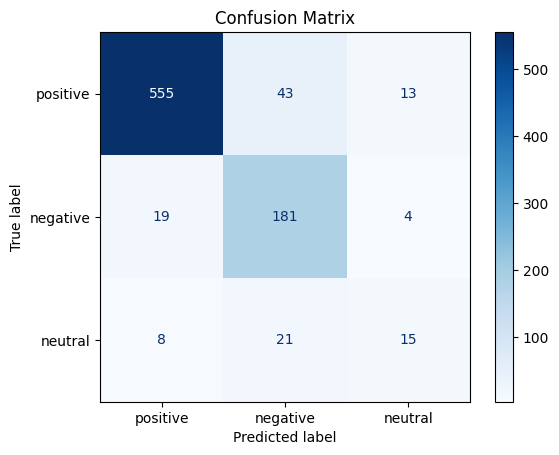

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=[0, 1, 2])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative', 'neutral'])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


In [28]:
def predict_sentiment(texts, aspects, tokenizer, model, device):
    model.eval()
    results = []

    label_map_rev = {0: 'positive', 1: 'negative', 2: 'neutral'}

    for text, aspect in zip(texts, aspects):
        input_text = text + " [SEP] " + aspect
        inputs = tokenizer(
            input_text,
            padding='max_length',
            max_length=128,
            truncation=True,
            return_tensors="pt"
        )

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.argmax(outputs.logits, dim=1).item()
            results.append({
                'text': text,
                'aspect': aspect,
                'predicted_label': label_map_rev[pred]
            })

    return results


In [29]:
# Sample custom inputs from user
texts = [
    "food is good but staff is very rude.",
    "The staff is very cooperative.",
    "I don't like the food layout."
]

aspects = [
    "FOOD#QUALITY",
    "SERVICE#GENERAL",
    "FOOD#QUALITY"
]

# Run prediction
results = predict_sentiment(texts, aspects, tokenizer, model, device)

# Print results
for res in results:
    print(f"Text: {res['text']}")
    print(f"Aspect: {res['aspect']}")
    print(f"Predicted Sentiment: {res['predicted_label']}\n")


Text: food is good but staff is very rude.
Aspect: FOOD#QUALITY
Predicted Sentiment: positive

Text: The staff is very cooperative.
Aspect: SERVICE#GENERAL
Predicted Sentiment: positive

Text: I don't like the food layout.
Aspect: FOOD#QUALITY
Predicted Sentiment: negative



In [30]:
# text = input("Enter a sentence: ")
# aspect = "laptop#general"


# result = predict_sentiment([text], [aspect], tokenizer, model, device)
# # print("Predicted Sentiment:", result[0]['predicted_label'])


In [31]:
# text = input("Enter a sentence: ")
# aspect = "battery#life"


# result = predict_sentiment([text], [aspect], tokenizer, model, device)
# print("Predicted Sentiment:", result[0]['predicted_label'])


In [32]:
# print(train_df['label'].value_counts())
